# Importations et préparation de l'environnement

In [1]:
import os

In [3]:
%cd ../data/raw/MVTec_AD

/Users/vcollumeau/ENSTA/anomaly_detection/data/raw/MVTec_AD


In [4]:
%ls

In [ ]:
if not os.path.exists('wood/'):
  !tar -xvf wood.tar.xz -C ./

In [ ]:
import os
import tarfile
from PIL import Image
from tqdm import tqdm
import urllib.request
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T

import argparse
import numpy as np
import os
import pickle
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2

# Définition du jeu de données

In [ ]:
CLASS_NAMES = ['wood']

In [ ]:
class MVTecDataset(Dataset):
  def __init__(self, root_path='../data/raw/MVTec_AD', class_name='wood', is_train = True, resize=256, cropsize=224):
    self.root_path = root_path
    self.class_name = class_name
    self.is_train = is_train
    self.resize = resize
    self.cropsize = cropsize
    self.mvtec_folder_path = root_path #if not using all the dataset
    #load dataset
    self.x, self.y, self.mask = self.load_dataset_folder()

    #set transforms
    self.transform_x = T.Compose([T.Resize(resize, Image.ANTIALIAS),
                                      T.CenterCrop(cropsize),
                                      T.ToTensor(),
                                      T.Normalize(mean=[0.485, 0.456, 0.406],
                                                  std=[0.229, 0.224, 0.225])])
    self.transform_mask = T.Compose([T.Resize(resize, Image.NEAREST),
                                      T.CenterCrop(cropsize),
                                      T.ToTensor()])
    
  def __getitem__(self, idx):
    x, y, mask = self.x[idx], self.y[idx], self.mask[idx]

    x = Image.open(x).convert('RGB')
    x = self.transform_x(x)

    if y == 0:
        mask = torch.zeros([1, self.cropsize, self.cropsize])
    else:
        mask = Image.open(mask)
        mask = self.transform_mask(mask)

    return x, y, mask
  def __len__(self):
    return len(self.x)
  
  def load_dataset_folder(self):
    phase = 'train' if self.is_train else 'test'
    x, y, mask = [], [], []

    img_dir = os.path.join(self.mvtec_folder_path, self.class_name, phase)
    gt_dir = os.path.join(self.mvtec_folder_path, self.class_name, 'ground_truth')

    img_types = sorted(os.listdir(img_dir))
    for img_type in img_types:

        # load images
        img_type_dir = os.path.join(img_dir, img_type)
        if not os.path.isdir(img_type_dir):
            continue
        img_fpath_list = sorted([os.path.join(img_type_dir, f) for f in os.listdir(img_type_dir) if f.endswith('.png')])
        x.extend(img_fpath_list)

        # load gt labels
        if img_type == 'good':
            y.extend([0] * len(img_fpath_list))
            mask.extend([None] * len(img_fpath_list))
        else:
            y.extend([1] * len(img_fpath_list))
            gt_type_dir = os.path.join(gt_dir, img_type)
            img_fname_list = [os.path.splitext(os.path.basename(f))[0] for f in img_fpath_list]
            gt_fpath_list = [os.path.join(gt_type_dir, img_fname + '_mask.png') for img_fname in img_fname_list]
            mask.extend(gt_fpath_list)

    assert len(x) == len(y), 'number of x and y should be same'

    return list(x), list(y), list(mask)

In [ ]:
def unnormalize(x, mu=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
  mu_hat=-1*torch.tensor(mu)
  std_hat=1/torch.tensor(std)
  mu_hat*=std_hat
  inv_normalize = T.Normalize(
    mean=mu_hat,
    std=std_hat
    )
    
  return inv_normalize(x)

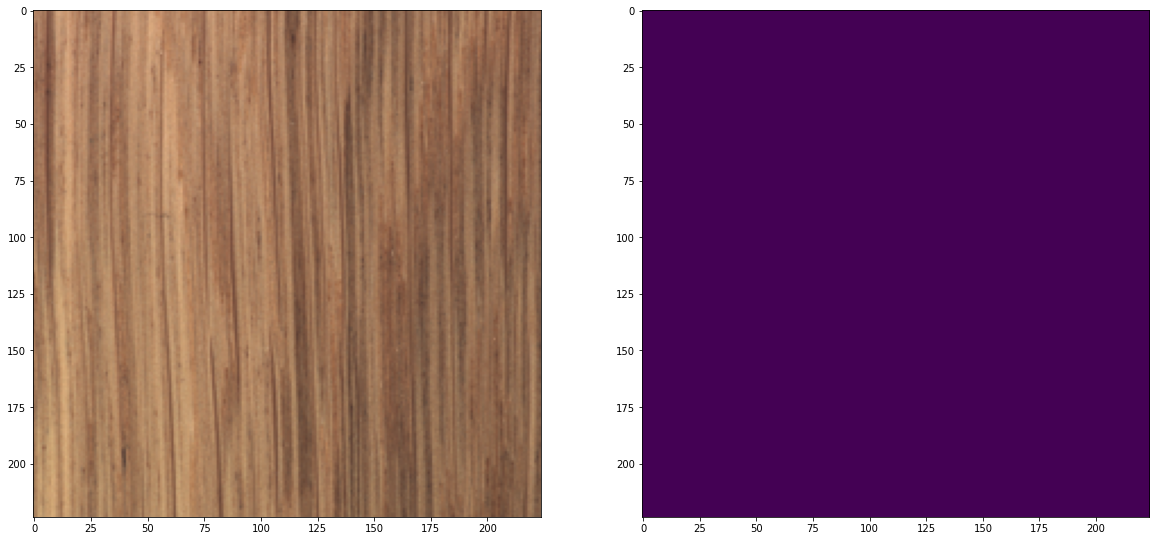

In [ ]:
dataset = MVTecDataset(class_name='wood', is_train=True, resize=256, cropsize=224)
x, y, mask = dataset[0]
x = unnormalize(x)
fig, ax =plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(x.permute(1,2,0))
ax[1].imshow(mask.squeeze())

# Définition du modèle

In [ ]:
# device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# load model
model = wide_resnet50_2(pretrained=True, progress=True)
model.to(device)
model.eval()
# set model's intermediate outputs
outputs = []
def hook(module, input, output):
    outputs.append(output)
model.layer1[-1].register_forward_hook(hook)
model.layer2[-1].register_forward_hook(hook)
model.layer3[-1].register_forward_hook(hook)
model.avgpool.register_forward_hook(hook)

cuda


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

## Extraction de features d'entrainement

In [ ]:
save_path='/'
os.makedirs(os.path.join(save_path, 'temp'), exist_ok=True)
for class_name in CLASS_NAMES:
  train_dataset = dataset
  train_dataloader = DataLoader(train_dataset, batch_size=32, pin_memory=True)
  test_dataset = MVTecDataset(class_name=class_name, is_train=False)
  test_dataloader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

  train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', []), ('avgpool', [])])
  test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', []), ('avgpool', [])])

  # extract train set features
  train_feature_filepath = os.path.join(save_path, 'temp', 'train_%s.pkl' % class_name)
  if not os.path.exists(train_feature_filepath):
      for (x, y, mask) in tqdm(train_dataloader, '| feature extraction | train | %s |' % class_name):
          # model prediction
          with torch.no_grad():
              pred = model(x.to(device))
          # get intermediate layer outputs
          for k, v in zip(train_outputs.keys(), outputs):
              print(k, v.shape)
              train_outputs[k].append(v)
          # initialize hook outputs
          outputs = []
      for k, v in train_outputs.items():
          train_outputs[k] = torch.cat(v, 0)
      # save extracted feature
      with open(train_feature_filepath, 'wb') as f:
          pickle.dump(train_outputs, f)
  else:
      print('load train set feature from: %s' % train_feature_filepath)
      with open(train_feature_filepath, 'rb') as f:
          train_outputs = pickle.load(f)

| feature extraction | train | wood |:  12%|█▎        | 1/8 [00:02<00:16,  2.40s/it]

layer1 torch.Size([32, 256, 56, 56])
layer2 torch.Size([32, 512, 28, 28])
layer3 torch.Size([32, 1024, 14, 14])
avgpool torch.Size([32, 2048, 1, 1])


| feature extraction | train | wood |:  25%|██▌       | 2/8 [00:04<00:13,  2.30s/it]

layer1 torch.Size([32, 256, 56, 56])
layer2 torch.Size([32, 512, 28, 28])
layer3 torch.Size([32, 1024, 14, 14])
avgpool torch.Size([32, 2048, 1, 1])


| feature extraction | train | wood |:  38%|███▊      | 3/8 [00:06<00:11,  2.26s/it]

layer1 torch.Size([32, 256, 56, 56])
layer2 torch.Size([32, 512, 28, 28])
layer3 torch.Size([32, 1024, 14, 14])
avgpool torch.Size([32, 2048, 1, 1])


| feature extraction | train | wood |:  50%|█████     | 4/8 [00:09<00:09,  2.25s/it]

layer1 torch.Size([32, 256, 56, 56])
layer2 torch.Size([32, 512, 28, 28])
layer3 torch.Size([32, 1024, 14, 14])
avgpool torch.Size([32, 2048, 1, 1])


| feature extraction | train | wood |:  62%|██████▎   | 5/8 [00:11<00:06,  2.20s/it]

layer1 torch.Size([32, 256, 56, 56])
layer2 torch.Size([32, 512, 28, 28])
layer3 torch.Size([32, 1024, 14, 14])
avgpool torch.Size([32, 2048, 1, 1])


| feature extraction | train | wood |:  75%|███████▌  | 6/8 [00:13<00:04,  2.20s/it]

layer1 torch.Size([32, 256, 56, 56])
layer2 torch.Size([32, 512, 28, 28])
layer3 torch.Size([32, 1024, 14, 14])
avgpool torch.Size([32, 2048, 1, 1])


| feature extraction | train | wood |:  88%|████████▊ | 7/8 [00:15<00:02,  2.21s/it]

layer1 torch.Size([32, 256, 56, 56])
layer2 torch.Size([32, 512, 28, 28])
layer3 torch.Size([32, 1024, 14, 14])
avgpool torch.Size([32, 2048, 1, 1])


| feature extraction | train | wood |: 100%|██████████| 8/8 [00:17<00:00,  2.15s/it]

layer1 torch.Size([23, 256, 56, 56])
layer2 torch.Size([23, 512, 28, 28])
layer3 torch.Size([23, 1024, 14, 14])
avgpool torch.Size([23, 2048, 1, 1])


In [ ]:
x.shape

torch.Size([23, 3, 224, 224])

In [ ]:
for k,v in train_outputs.items():
  print(k, v.shape)

#train_outputs['layer1'].shape

layer1 torch.Size([247, 256, 56, 56])
layer2 torch.Size([247, 512, 28, 28])
layer3 torch.Size([247, 1024, 14, 14])
avgpool torch.Size([247, 2048, 1, 1])


## Extraction de features de test

In [ ]:
gt_list = []
gt_mask_list = []
test_imgs = []

# extract test set features
for (x, y, mask) in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
    test_imgs.extend(x.cpu().detach().numpy())
    gt_list.extend(y.cpu().detach().numpy())
    gt_mask_list.extend(mask.cpu().detach().numpy())
    # model prediction
    with torch.no_grad():
        pred = model(x.to(device))
    # get intermediate layer outputs
    for k, v in zip(test_outputs.keys(), outputs):
        test_outputs[k].append(v)
    # initialize hook outputs
    outputs = []
for k, v in test_outputs.items():
    test_outputs[k] = torch.cat(v, 0)

| feature extraction | test | wood |: 100%|██████████| 3/3 [00:05<00:00,  1.98s/it]


In [ ]:
for k,v in test_outputs.items():
  print(k, v.shape)

layer1 torch.Size([79, 256, 56, 56])
layer2 torch.Size([79, 512, 28, 28])
layer3 torch.Size([79, 1024, 14, 14])
avgpool torch.Size([79, 2048, 1, 1])


## Matrice des distances

In [ ]:
top_k=5
# calculate distance matrix
def calc_dist_matrix(x, y):
    """Calculate Euclidean distance matrix with torch.tensor"""
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    dist_matrix = torch.sqrt(torch.pow(x - y, 2).sum(2))
    return dist_matrix
dist_matrix = calc_dist_matrix(torch.flatten(test_outputs['avgpool'], 1),
                                torch.flatten(train_outputs['avgpool'], 1))
print('dist_matrix',dist_matrix.shape)

topk_values, topk_indexes = torch.topk(dist_matrix, k=top_k, dim=1, largest=False)
scores = torch.mean(topk_values, 1).cpu().detach().numpy()
topk_indexes.shape
print(scores.shape)
print(test_outputs['avgpool'].shape)


dist_matrix torch.Size([79, 247])
(79,)
torch.Size([79, 2048, 1, 1])


## Features-map et score-map

In [ ]:
score_map_list = []
for t_idx in tqdm(range(test_outputs['avgpool'].shape[0]), '| localization | test | %s |' % class_name):
    score_maps = []
    for layer_name in ['layer1', 'layer2', 'layer3']:  # for each layer

        # construct a gallery of features at all pixel locations of the K nearest neighbors
        topk_feat_map = train_outputs[layer_name][topk_indexes[t_idx]]
        test_feat_map = test_outputs[layer_name][t_idx:t_idx + 1]
        feat_gallery = topk_feat_map.transpose(3, 1).flatten(0, 2).unsqueeze(-1).unsqueeze(-1)

        # calculate distance matrix
        dist_matrix_list = []
        for d_idx in range(feat_gallery.shape[0] // 100):
            dist_matrix = torch.pairwise_distance(feat_gallery[d_idx * 100:d_idx * 100 + 100], test_feat_map)
            dist_matrix_list.append(dist_matrix)
        dist_matrix = torch.cat(dist_matrix_list, 0)
        
        # k nearest features from the gallery (k=1)
        score_map = torch.min(dist_matrix, dim=0)[0]
        score_map = F.interpolate(score_map.unsqueeze(0).unsqueeze(0), size=224,
                                    mode='bilinear', align_corners=False)
        score_maps.append(score_map)

    # average distance between the features
    score_map = torch.mean(torch.cat(score_maps, 0), dim=0)

    # apply gaussian smoothing on the score map
    score_map = gaussian_filter(score_map.squeeze().cpu().detach().numpy(), sigma=4)
    score_map_list.append(score_map)
def denormalization(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)
    return x


| localization | test | wood |: 100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


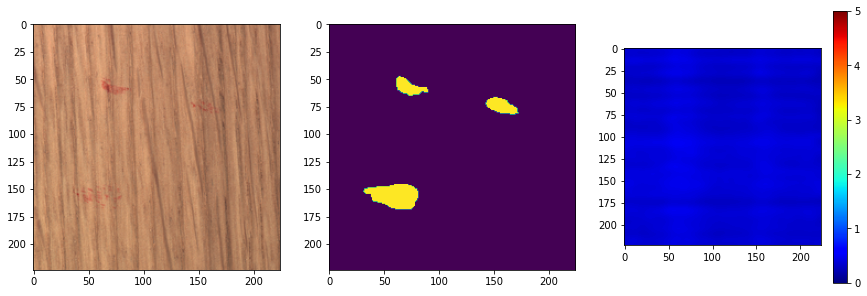

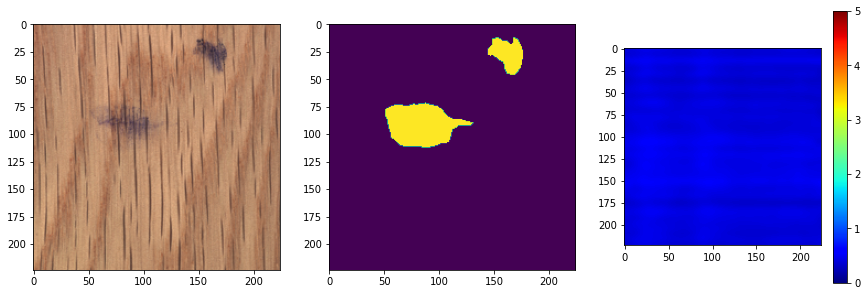

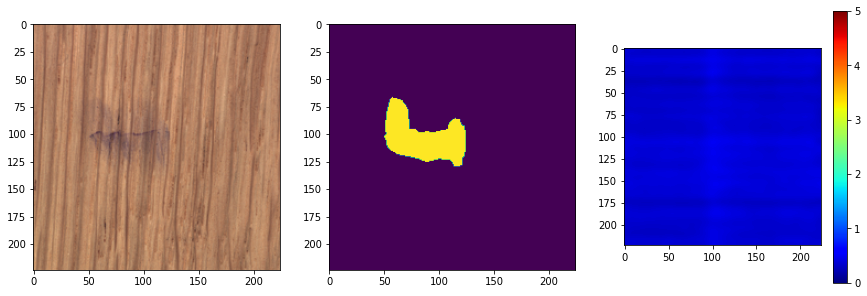

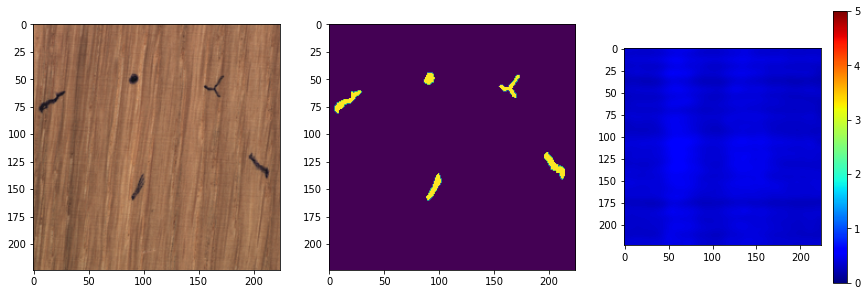

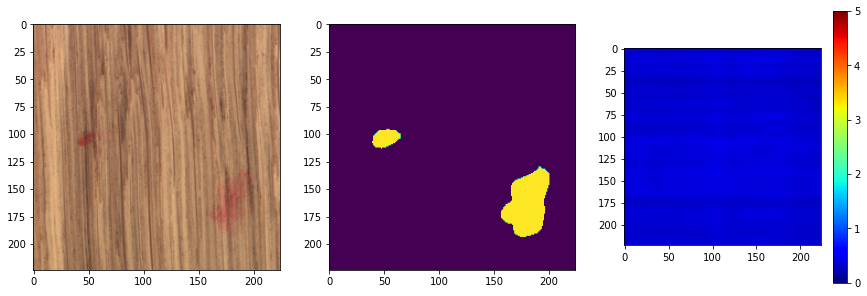

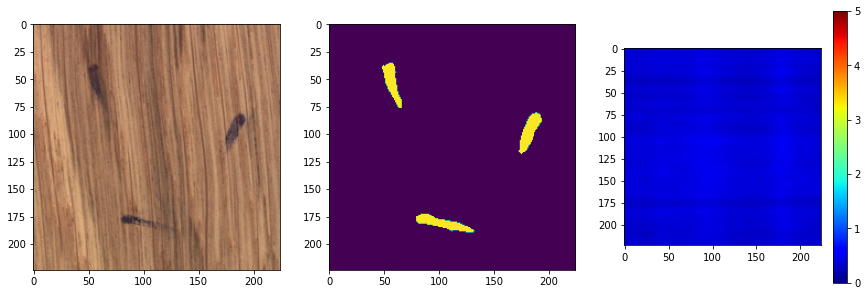

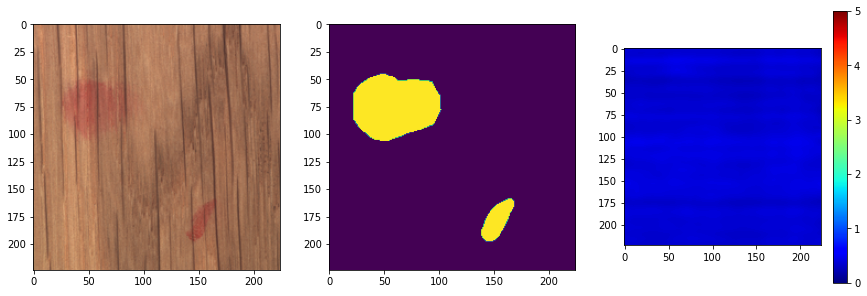

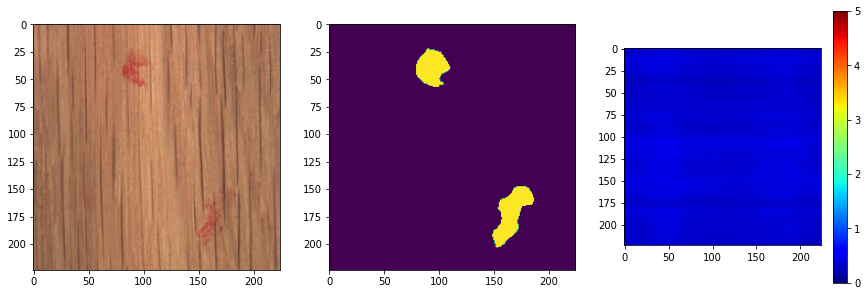

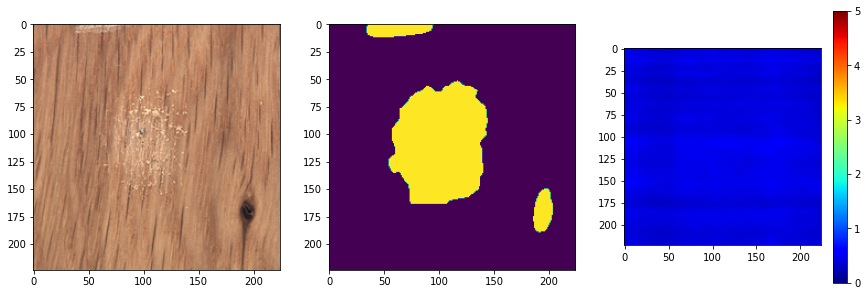

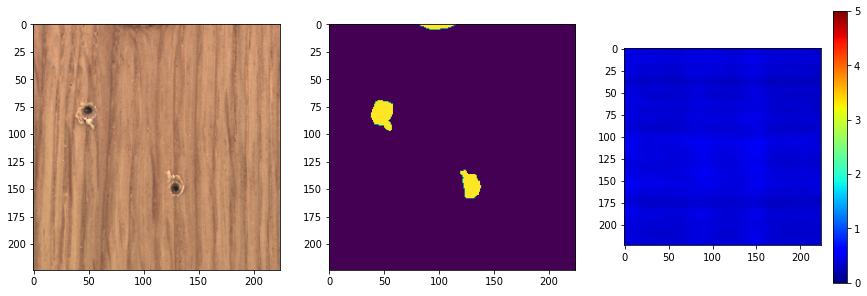

In [ ]:
for id_ in range(10):
    x=denormalization(test_imgs[id_])
    gt=gt_mask_list[id_]
    anno_map=score_map_list[id_]
    fig, ax=plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(x)
    ax[1].imshow(gt.squeeze())
    im = ax[2].imshow(anno_map, cmap='jet',vmin=0,vmax=5)
    fig.colorbar(im, ax=ax[2])

## Résultats

In [ ]:
def visualize_loc_result(test_imgs, gt_mask_list, score_map_list, threshold,
                         save_path, class_name, vis_num=5):

    for t_idx in range(vis_num):
        test_img = test_imgs[t_idx]
        test_img = denormalization(test_img)
        test_gt = gt_mask_list[t_idx].transpose(1, 2, 0).squeeze()
        test_pred = score_map_list[t_idx]
        test_pred[test_pred <= threshold] = 0
        test_pred[test_pred > threshold] = 1
        test_pred_img = test_img.copy()
        test_pred_img[test_pred == 0] = 0

        fig_img, ax_img = plt.subplots(1, 4, figsize=(12, 4))
        fig_img.subplots_adjust(left=0, right=1, bottom=0, top=1)

        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)

        ax_img[0].imshow(test_img)
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(test_gt, cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax_img[2].imshow(test_pred, cmap='gray')
        ax_img[2].title.set_text('Predicted mask')
        ax_img[3].imshow(test_pred_img)
        ax_img[3].title.set_text('Predicted anomalous image')

        os.makedirs(os.path.join(save_path, 'images'), exist_ok=True)
        fig_img.savefig(os.path.join(save_path, 'images', '%s_%03d.png' % (class_name, t_idx)), dpi=100)
        fig_img.clf()
        plt.close(fig_img)

# Lancement de l'entrainement et tests

| feature extraction | train | wood |: 100%|██████████| 8/8 [00:16<00:00,  2.11s/it]
| feature extraction | test | wood |: 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


wood ROCAUC: 0.958


| localization | test | wood |: 100%|██████████| 79/79 [01:46<00:00,  1.35s/it]


wood pixel ROCAUC: 0.644
Average ROCAUC: 0.958
Average pixel ROCUAC: 0.644


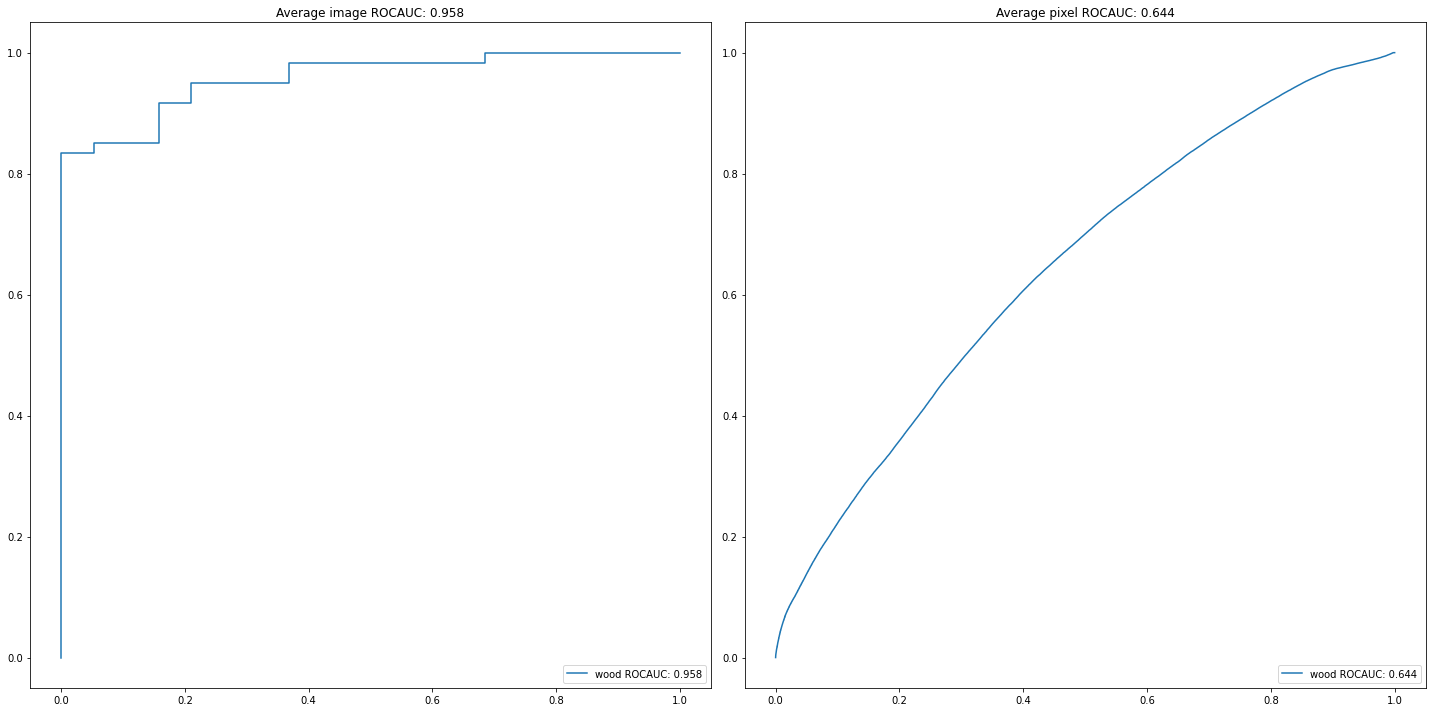

In [ ]:
'''
def parse_args():
    parser = argparse.ArgumentParser('SPADE')
    parser.add_argument("--top_k", type=int, default=5)
    parser.add_argument("--save_path", type=str, default="./result")
    return parser.parse_args()
'''

def main(top_k, save_path):

    #args = parse_args()
    
    # device setup
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # load model
    model = wide_resnet50_2(pretrained=True, progress=True)
    model.to(device)
    model.eval()

    # set model's intermediate outputs
    outputs = []
    def hook(module, input, output):
        outputs.append(output)
    model.layer1[-1].register_forward_hook(hook)
    model.layer2[-1].register_forward_hook(hook)
    model.layer3[-1].register_forward_hook(hook)
    model.avgpool.register_forward_hook(hook)

    os.makedirs(os.path.join(save_path, 'temp'), exist_ok=True)

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    fig_img_rocauc = ax[0]
    fig_pixel_rocauc = ax[1]

    total_roc_auc = []
    total_pixel_roc_auc = []

    for class_name in CLASS_NAMES:

        train_dataset = MVTecDataset(class_name=class_name, is_train=True)
        train_dataloader = DataLoader(train_dataset, batch_size=32, pin_memory=True)
        test_dataset = MVTecDataset(class_name=class_name, is_train=False)
        test_dataloader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

        train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', []), ('avgpool', [])])
        test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', []), ('avgpool', [])])

        # extract train set features
        train_feature_filepath = os.path.join(save_path, 'temp', 'train_%s.pkl' % class_name)
        if not os.path.exists(train_feature_filepath):
            for (x, y, mask) in tqdm(train_dataloader, '| feature extraction | train | %s |' % class_name):
                # model prediction
                with torch.no_grad():
                    pred = model(x.to(device))
                # get intermediate layer outputs
                for k, v in zip(train_outputs.keys(), outputs):
                    train_outputs[k].append(v)
                # initialize hook outputs
                outputs = []
            for k, v in train_outputs.items():
                train_outputs[k] = torch.cat(v, 0)
            # save extracted feature
            with open(train_feature_filepath, 'wb') as f:
                pickle.dump(train_outputs, f)
        else:
            print('load train set feature from: %s' % train_feature_filepath)
            with open(train_feature_filepath, 'rb') as f:
                train_outputs = pickle.load(f)

        gt_list = []
        gt_mask_list = []
        test_imgs = []

        # extract test set features
        for (x, y, mask) in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
            test_imgs.extend(x.cpu().detach().numpy())
            gt_list.extend(y.cpu().detach().numpy())
            gt_mask_list.extend(mask.cpu().detach().numpy())
            # model prediction
            with torch.no_grad():
                pred = model(x.to(device))
            # get intermediate layer outputs
            for k, v in zip(test_outputs.keys(), outputs):
                test_outputs[k].append(v)
            # initialize hook outputs
            outputs = []
        for k, v in test_outputs.items():
            test_outputs[k] = torch.cat(v, 0)

        # calculate distance matrix
        dist_matrix = calc_dist_matrix(torch.flatten(test_outputs['avgpool'], 1),
                                       torch.flatten(train_outputs['avgpool'], 1))

        # select K nearest neighbor and take average
        topk_values, topk_indexes = torch.topk(dist_matrix, k=top_k, dim=1, largest=False)
        scores = torch.mean(topk_values, 1).cpu().detach().numpy()

        # calculate image-level ROC AUC score
        fpr, tpr, _ = roc_curve(gt_list, scores)
        roc_auc = roc_auc_score(gt_list, scores)
        total_roc_auc.append(roc_auc)
        print('%s ROCAUC: %.3f' % (class_name, roc_auc))
        fig_img_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (class_name, roc_auc))

        score_map_list = []
        for t_idx in tqdm(range(test_outputs['avgpool'].shape[0]), '| localization | test | %s |' % class_name):
            score_maps = []
            for layer_name in ['layer1', 'layer2', 'layer3']:  # for each layer

                # construct a gallery of features at all pixel locations of the K nearest neighbors
                topk_feat_map = train_outputs[layer_name][topk_indexes[t_idx]]
                test_feat_map = test_outputs[layer_name][t_idx:t_idx + 1]
                feat_gallery = topk_feat_map.transpose(3, 1).flatten(0, 2).unsqueeze(-1).unsqueeze(-1)

                # calculate distance matrix
                dist_matrix_list = []
                for d_idx in range(feat_gallery.shape[0] // 100):
                    dist_matrix = torch.pairwise_distance(feat_gallery[d_idx * 100:d_idx * 100 + 100], test_feat_map)
                    dist_matrix_list.append(dist_matrix)
                dist_matrix = torch.cat(dist_matrix_list, 0)

                # k nearest features from the gallery (k=1)
                score_map = torch.min(dist_matrix, dim=0)[0]
                score_map = F.interpolate(score_map.unsqueeze(0).unsqueeze(0), size=224,
                                          mode='bilinear', align_corners=False)
                score_maps.append(score_map)

            # average distance between the features
            score_map = torch.mean(torch.cat(score_maps, 0), dim=0)

            # apply gaussian smoothing on the score map
            score_map = gaussian_filter(score_map.squeeze().cpu().detach().numpy(), sigma=4)
            score_map_list.append(score_map)

        flatten_gt_mask_list = np.concatenate(gt_mask_list).ravel()
        flatten_score_map_list = np.concatenate(score_map_list).ravel()

        # calculate per-pixel level ROCAUC
        fpr, tpr, _ = roc_curve(flatten_gt_mask_list, flatten_score_map_list)
        per_pixel_rocauc = roc_auc_score(flatten_gt_mask_list, flatten_score_map_list)
        total_pixel_roc_auc.append(per_pixel_rocauc)
        print('%s pixel ROCAUC: %.3f' % (class_name, per_pixel_rocauc))
        fig_pixel_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (class_name, per_pixel_rocauc))

        # get optimal threshold
        precision, recall, thresholds = precision_recall_curve(flatten_gt_mask_list, flatten_score_map_list)
        a = 2 * precision * recall
        b = precision + recall
        f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
        threshold = thresholds[np.argmax(f1)]

        # visualize localization result
        visualize_loc_result(test_imgs, gt_mask_list, score_map_list, threshold, save_path, class_name, vis_num=5)

    print('Average ROCAUC: %.3f' % np.mean(total_roc_auc))
    fig_img_rocauc.title.set_text('Average image ROCAUC: %.3f' % np.mean(total_roc_auc))
    fig_img_rocauc.legend(loc="lower right")

    print('Average pixel ROCUAC: %.3f' % np.mean(total_pixel_roc_auc))
    fig_pixel_rocauc.title.set_text('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
    fig_pixel_rocauc.legend(loc="lower right")

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, 'roc_curve.png'), dpi=100)


def calc_dist_matrix(x, y):
    """Calculate Euclidean distance matrix with torch.tensor"""
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)
    dist_matrix = torch.sqrt(torch.pow(x - y, 2).sum(2))
    return dist_matrix


def visualize_loc_result(test_imgs, gt_mask_list, score_map_list, threshold,
                         save_path, class_name, vis_num=5):

    for t_idx in range(vis_num):
        test_img = test_imgs[t_idx]
        test_img = denormalization(test_img)
        test_gt = gt_mask_list[t_idx].transpose(1, 2, 0).squeeze()
        test_pred = score_map_list[t_idx]
        test_pred[test_pred <= threshold] = 0
        test_pred[test_pred > threshold] = 1
        test_pred_img = test_img.copy()
        test_pred_img[test_pred == 0] = 0

        fig_img, ax_img = plt.subplots(1, 4, figsize=(12, 4))
        fig_img.subplots_adjust(left=0, right=1, bottom=0, top=1)

        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)

        ax_img[0].imshow(test_img)
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(test_gt, cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax_img[2].imshow(test_pred, cmap='gray')
        ax_img[2].title.set_text('Predicted mask')
        ax_img[3].imshow(test_pred_img)
        ax_img[3].title.set_text('Predicted anomalous image')

        os.makedirs(os.path.join(save_path, 'images'), exist_ok=True)
        fig_img.savefig(os.path.join(save_path, 'images', '%s_%03d.png' % (class_name, t_idx)), dpi=100)
        fig_img.clf()
        plt.close(fig_img)


def denormalization(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)
    return x


if __name__ == '__main__':
    main(5, "./result")